In [6]:
'''
File: RetinaNetModelEvaluatorEvaluator.ipynb
Author: Ishir Garg (ishirgarg@berkeley.edu)
Date: 3/28/24

Evaluator for RetinaNet model
'''
import sys
sys.path.append("../")
sys.path.append("../../model_evaluation")

from ModelEvaluator import ModelEvaluator
import numpy as np
import cv2
import torch
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import functools

In [7]:
class RetinaNetModelEvaluator(ModelEvaluator):
    def load_model(self):
        num_classes = 1 # Tree and background
        model = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1)
        # replace classification layer 
        num_anchors = model.head.classification_head.num_anchors

        model.head.classification_head = RetinaNetClassificationHead(
                in_channels=256,
                num_anchors=num_anchors,
                num_classes=num_classes,
                norm_layer=functools.partial(torch.nn.GroupNorm, 32)
            )
        
        model.load_state_dict(torch.load("./m.pt"))
        model.eval()
        return model
    
    def predict_image(self, model, rgb_image) -> dict:
        bgr_image = rgb_image[:,:,::-1].transpose((2, 0, 1)) / 255
        with torch.no_grad():
            result = model(torch.Tensor(np.array([bgr_image])))[0]

        return {
            "bboxes": result["boxes"].detach().numpy(),
            "scores": result["scores"].detach().numpy()
        }
    

In [8]:
evaluator = RetinaNetModelEvaluator("/Users/ishirgarg/Github/UAV_Playground/NEON/single_evaluation", "/Users/ishirgarg/Github/UAV_Playground/NEON/annotations")

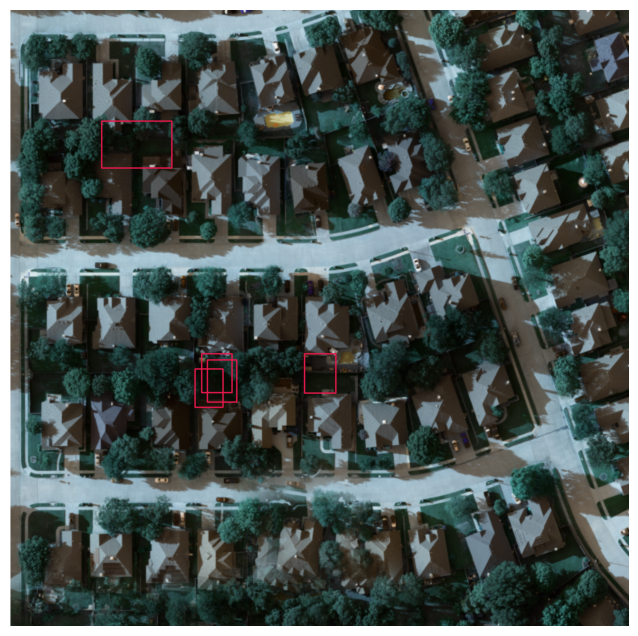

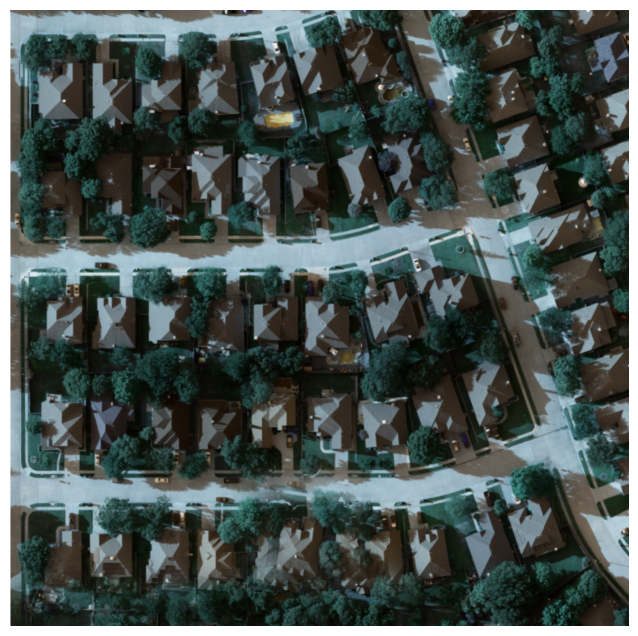

In [9]:
img = cv2.imread("../../test_images/test2.png")[:, :, ::-1]
evaluator.eval_and_plot_image_annotations(img, np.array([]), confidence_threshold=0.2, nms_threshold=0.75, size=(8, 8), nms_type="iomin")

In [10]:
detections = evaluator.evaluate_model(confidence_threshold=0, iou_threshold=0.25, nms_threshold=0.25, nms_type="iomin")

print(detections["metrics"])

{'map': tensor(0.), 'precision': 0.043651536259608124, 'recall': 0.3452380952380952, 'f1': 0.07750360005457105}


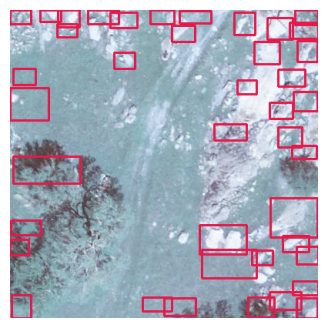

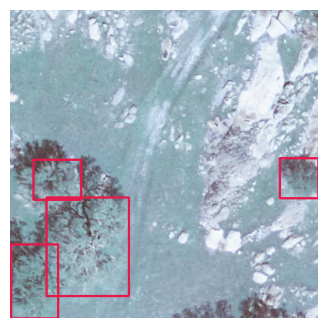

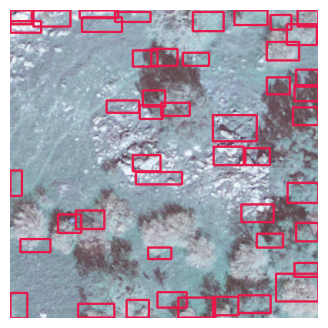

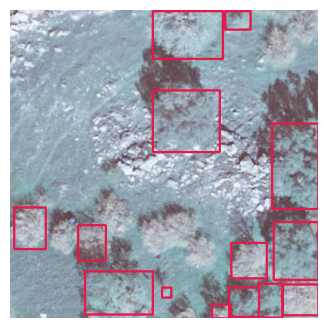

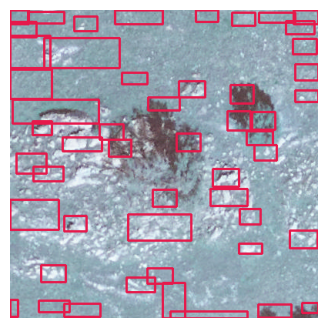

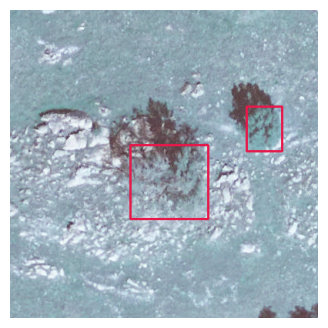

In [11]:
for i in range(evaluator.dataset_len()):
    evaluator.plot_image_annotations(i, (4,4))